In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import torchvision.transforms.functional as F
from pytorch_fid import fid_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
batch_size = 32
source_data_path = 'data/source_data'
img_size = 64
img_channels = 3
real_label = 1
fake_label = 0

# Net params
latent_dim_values = [1, 2, 4, 8, 16, 32, 64, 128]
d_hidden_values = [64]
g_hidden_values = [64]

# Optimizer params
lr_gen_values = [0.001, 0.0005, 0.0002, 0.0001, 0.00005]
beta1_gen_values = [0.5, 0.9]
beta2_gen_values = [0.999]
lr_dis_values = [0.001, 0.0005, 0.0002, 0.0001, 0.00005]
beta1_dis_values = [0.5, 0.9]
beta2_dis_values = [0.999]

num_epochs = 5

# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

dataset = ImageFolder(root=source_data_path, transform=data_transform)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size, g_hidden):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.g_hidden = g_hidden
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, g_hidden * self.init_size ** 2))

        self.model = nn.Sequential(
            nn.BatchNorm2d(g_hidden),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(g_hidden, g_hidden // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(g_hidden // 2, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(g_hidden // 2, g_hidden // 4, 3, stride=1, padding=1),
            nn.BatchNorm2d(g_hidden // 4, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(g_hidden // 4, img_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], self.g_hidden, self.init_size, self.init_size)
        img = self.model(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size, d_hidden):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, d_hidden, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_hidden, d_hidden * 2, 3, 2, 1),
            nn.BatchNorm2d(d_hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_hidden * 2, d_hidden * 4, 3, 2, 1),
            nn.BatchNorm2d(d_hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(d_hidden * 4, 1, 3, 1, 0),  # Change the number of output channels to 1
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)  # Flatten to shape [batch_size, 1]



In [3]:
# Plot loss curves
def plot_train_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.plot(generator_losses, label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Training Loss')
    plt.show()

def generate_n_image(num_images_to_generate, generator, latent_dim):
    generator.eval()
    # Generate random noise
    z = torch.randn(num_images_to_generate, latent_dim, device=device)
    # Generate images using the generator
    generated_images = generator(z)

    fig, axes = plt.subplots(1, num_images_to_generate, figsize=(15, 3))

    for i in range(num_images_to_generate):
        img_np = generated_images[i].detach().cpu().numpy().transpose((1, 2, 0))
        axes[i].imshow(img_np)
        axes[i].axis('off')

    plt.show()

    generator.train()

In [4]:
def calculate_inception_score(generator, latent_dim, num_samples, device='cuda'):
    # Generate samples
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        generated_images = generator(z).detach().cpu()
    # Compute Inception Score
    # Implement Inception Score calculation here
    inception_score = 0  # Dummy value, replace with actual calculation
    return inception_score

def calculate_frechet_inception_distance(generator, latent_dim, data_loader, device='cuda'):
    # Generate samples
    with torch.no_grad():
        z = torch.randn(len(data_loader.dataset), latent_dim, device=device)
        generated_images = generator(z).detach().cpu()
    # Compute FID
    # Implement FID calculation here
    fid_score = 0  # Dummy value, replace with actual calculation
    return fid_score


In [12]:
def train_gan(n_epochs, latent_dim, lr_gen, beta1_gen, beta2_gen, lr_dis, beta1_dis, beta2_dis, g_hidden, d_hidden, img_channels, img_size, data_loader, device):
    # Create GAN
    generator = Generator(latent_dim, img_channels, img_size, g_hidden)
    generator.apply(weights_init)
    discriminator = Discriminator(img_channels, img_size, d_hidden)
    discriminator.apply(weights_init)
    adversarial_loss = nn.BCELoss()

    # noise
    viz_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)

    # Move to GPU
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    adversarial_loss = adversarial_loss.to(device)

    # Create optimizers for the generator and discriminator
    generator_optimizer = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1_gen, beta2_gen))
    discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(beta1_dis, beta2_dis))

    generator_losses = []
    discriminator_losses = []

    best_epoch = 0
    best_loss = float('inf')  # Initialize with a very large value for minimization

    print_interval = 10
    epoch_discriminator_loss_list = []
    epoch_generator_loss_list = []

    for epoch in range(n_epochs):
        epoch_discriminator_loss = 0.0
        epoch_generator_loss = 0.0
        for batch_idx, (real_images, _) in enumerate(data_loader):
            real_images = real_images.to(device)

            # Training the discriminator
            discriminator_optimizer.zero_grad()

            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)

            real_labels = torch.full((real_images.size(0),), real_label, device=device)
            fake_labels = torch.full((real_images.size(0),), fake_label, device=device)

            real_output = discriminator(real_images).view(-1)
            fake_output = discriminator(fake_images.detach()).view(-1)
            fake_labels = torch.full_like(fake_output, fake_label)
            real_labels = torch.full_like(real_output, real_label)

            real_loss = adversarial_loss(real_output, real_labels)
            fake_loss = adversarial_loss(fake_output, fake_labels)
            discriminator_loss = (real_loss + fake_loss)

            discriminator_loss.backward()
            discriminator_optimizer.step()

            # Training the generator
            generator_optimizer.zero_grad()

            z = torch.randn(real_images.size(0), latent_dim, device=device)
            fake_images = generator(z)

            fake_output = discriminator(fake_images).view(-1)
            generator_loss = adversarial_loss(fake_output, real_labels)  # Use real_labels for generator loss

            generator_loss.backward()
            generator_optimizer.step()

            discriminator_losses.append(discriminator_loss.item())
            generator_losses.append(generator_loss.item())

            epoch_discriminator_loss += discriminator_loss.item()
            epoch_generator_loss += generator_loss.item()
            if batch_idx % print_interval == 0:
                print(f"Epoch [{epoch}/{n_epochs}], Batch [{batch_idx}/{len(data_loader)}], "
                      f"Discriminator Loss: {discriminator_loss.item():.4f}, "
                      f"Generator Loss: {generator_loss.item():.4f}")

        # Validation Metrics
        # Calculate IS or FID
        inception_score = calculate_inception_score(generator, latent_dim, num_samples=1000, device=device)
        fid_score = calculate_frechet_inception_distance(generator, latent_dim, data_loader, device=device)

        epoch_discriminator_loss /= len(data_loader)
        epoch_generator_loss /= len(data_loader)

        epoch_discriminator_loss_list.append(epoch_discriminator_loss)
        epoch_generator_loss_list.append(epoch_generator_loss)
        epoch_combined_loss = epoch_discriminator_loss + epoch_generator_loss
        # Check if this epoch has the best loss or score
        if epoch_combined_loss < best_loss:
            best_loss = epoch_combined_loss
            best_epoch = epoch
            # Save the weights
            torch.save(generator.state_dict(), 'best_generator_weights.pth')
            torch.save(discriminator.state_dict(), 'best_discriminator_weights.pth')
        print(f"Epoch [{epoch}/{n_epochs}], Avg. Discriminator Loss: {epoch_discriminator_loss:.4f}, "
              f"Avg. Generator Loss: {epoch_generator_loss:.4f}, "
              f"FID: {fid_score:.4f}, "
              f"IS: {inception_score:.4f}, "
              f" -- Combined Loss: {epoch_combined_loss:.4f} -- ")

    print(f"Best epoch: {best_epoch}, Best Combined loss: {best_loss}")
            

    return discriminator_losses, generator_losses, generator, discriminator

Epoch [0/5], Batch [0/38], Discriminator Loss: 1.3762, Generator Loss: 0.9147
Epoch [0/5], Batch [10/38], Discriminator Loss: 0.7275, Generator Loss: 1.3726
Epoch [0/5], Batch [20/38], Discriminator Loss: 0.7656, Generator Loss: 1.3026
Epoch [0/5], Batch [30/38], Discriminator Loss: 0.8356, Generator Loss: 1.2282
Epoch [0/5], Avg. Discriminator Loss: 0.7876, Avg. Generator Loss: 1.3071, FID: 0.0000, IS: 0.0000,  -- Combined Loss: 2.0947 -- 
Epoch [1/5], Batch [0/38], Discriminator Loss: 0.9084, Generator Loss: 1.1242
Epoch [1/5], Batch [10/38], Discriminator Loss: 0.9178, Generator Loss: 1.1549
Epoch [1/5], Batch [20/38], Discriminator Loss: 0.7050, Generator Loss: 1.5245
Epoch [1/5], Batch [30/38], Discriminator Loss: 0.9756, Generator Loss: 1.1385
Epoch [1/5], Avg. Discriminator Loss: 0.9027, Avg. Generator Loss: 1.1883, FID: 0.0000, IS: 0.0000,  -- Combined Loss: 2.0910 -- 
Epoch [2/5], Batch [0/38], Discriminator Loss: 1.1322, Generator Loss: 1.0374
Epoch [2/5], Batch [10/38], Disc

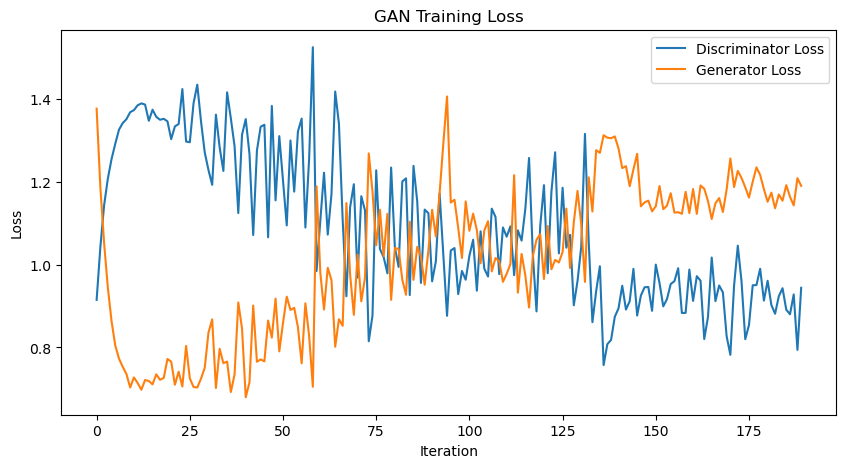

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


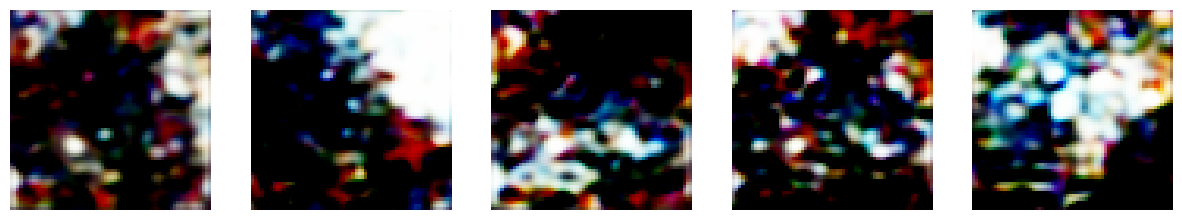

In [16]:
# Train GAN with convolutional layers
generator_losses, discriminator_losses, generator, discriminator = train_gan(
    5,
    4,
    0.0005,
    0.5,
    0.999,
    0.0001,
    0.5,
    0.999,
    g_hidden_values[0],
    d_hidden_values[0],
    img_channels,
    img_size,
    data_loader,
    device
)

# Plot loss curves
plot_train_losses(generator_losses, discriminator_losses)
# Generate images
generate_n_image(5, generator, latent_dim_values[2])


In [ ]:
# Assuming you've defined your models and their architectures
generator1 = Generator(latent_dim_values[4], img_channels, img_size, g_hidden_values[0])
discriminator1 = Discriminator(img_channels, img_size, d_hidden_values[0])

# Load the weights
generator1.load_state_dict(torch.load('best_generator_weights.pth'))
discriminator1.load_state_dict(torch.load('best_discriminator_weights.pth'))

generator1.to(device)
discriminator1.to(device)



Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1))
    (9): Sigmoid()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


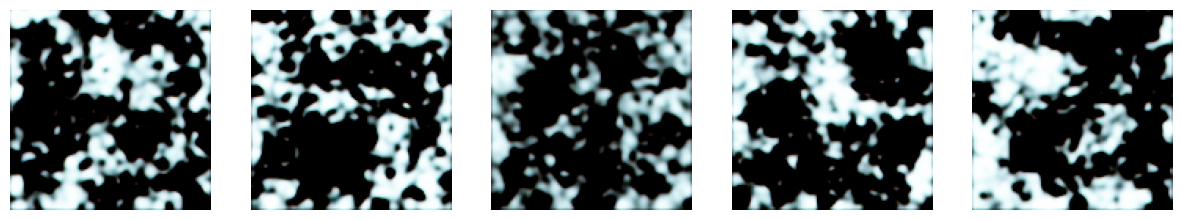

In [10]:
generate_n_image(5,generator1, latent_dim_values[4])
